In [1]:
import os
from os.path import join
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Load assemblies

In [104]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
complete_genomes_df = assembly_df[assembly_df['assembly_level'] == 'Complete Genome'].copy()
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


## Compare AA vs tri-nucleotide results

In [3]:
def load_global_bias_results(kind, query_type, tail='left'):
    if kind == 'tri-nucleotide':
        path = join(cwd, f'data/{query_type}_probability_{tail}.csv')
    else:
        path = join(cwd, f'data/{query_type}_aa_probability_{tail}.csv')
        
    df = pd.read_csv(path, index_col='id' if query_type == 'tigr' else 'query')
    df['rank'] = list(range(1, len(df) + 1))
    return df

In [4]:
pfam_tri = load_global_bias_results('tri-nucleotide', 'pfam')
tigr_tri = load_global_bias_results('tri-nucleotide', 'tigr')

pfam_aa = load_global_bias_results('amino-acid', 'pfam')
tigr_aa = load_global_bias_results('amino-acid', 'tigr')

In [5]:
def compute_difference_in_place(tri_df, aa_df):
    indices = set(tri_df.index.tolist()) & set(aa_df.index.tolist())
    tri_df_copy = tri_df.loc[indices].sort_values('rank').copy()
    tri_df_copy['rank'] = range(1, len(indices) + 1)
    for ix in indices:
        tri_rank = tri_df_copy.loc[ix]['rank']
        aa_rank = aa_df.loc[ix]['rank']
        aa_df.loc[ix, 'rank_tri'] = tri_rank
        aa_df.loc[ix, 'rank_aa'] = aa_rank
        aa_df.loc[ix, 'rank_diff'] = tri_rank - aa_rank
        aa_df.loc[ix, 'rank_diff_abs'] = np.abs(tri_rank - aa_rank)

In [6]:
compute_difference_in_place(pfam_tri, pfam_aa)
compute_difference_in_place(tigr_tri, tigr_aa)

In [7]:
trna_synt_tigr_id = tigr_aa[
    tigr_aa['description'].notnull() & 
    tigr_aa['description'].str.contains('--tRNA ligase')
].index
len(trna_synt_tigr_id)

35

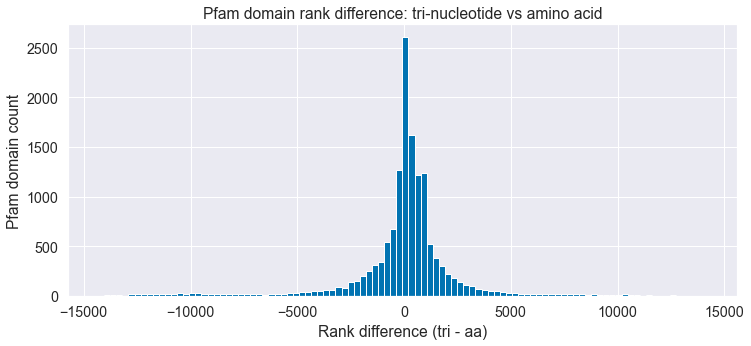

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(pfam_aa[pfam_aa['rank_diff'].notnull()]['rank_diff'].values, bins=100);
ax.set_title('Pfam domain rank difference: tri-nucleotide vs amino acid');
ax.set_xlabel('Rank difference (tri - aa)');
ax.set_ylabel('Pfam domain count');

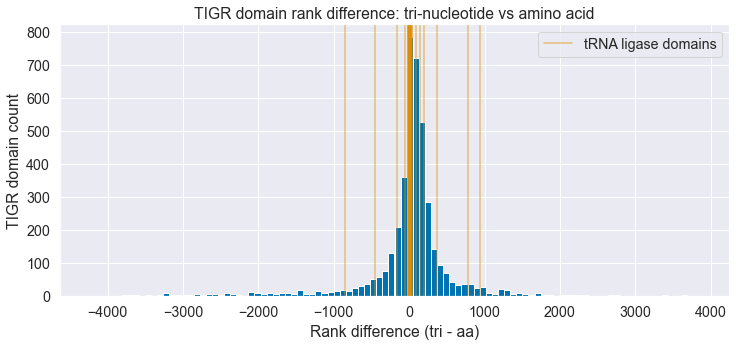

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(tigr_aa[tigr_aa['rank_diff'].notnull()]['rank_diff'].values, bins=100);

for i, tigr_id in enumerate(trna_synt_tigr_id):
    label = 'tRNA ligase domains' if i == 0 else None
    ax.axvline(tigr_aa.loc[tigr_id]['rank_diff'], color=palette[1], alpha=0.5, label=label)

ax.set_title('TIGR domain rank difference: tri-nucleotide vs amino acid');
ax.set_xlabel('Rank difference (tri - aa)');
ax.set_ylabel('TIGR domain count');
ax.legend();

In [10]:
tigr_aa_out_df = tigr_aa.loc[trna_synt_tigr_id].sort_values('rank_diff_abs', ascending=True)[
    ['query', 'description', 'rank_tri', 'rank_aa', 'rank_diff']
].copy()
tigr_aa_out_df['rank_tri'] = tigr_aa_out_df['rank_tri'].astype(int)
tigr_aa_out_df['rank_aa'] = tigr_aa_out_df['rank_aa'].astype(int)
tigr_aa_out_df['rank_diff'] = tigr_aa_out_df['rank_diff'].astype(int)
tigr_aa_out_df.to_csv('/Users/srom/Downloads/tigr_aa_diff.csv');
tigr_aa_out_df

,query,description,rank_tri,rank_aa,rank_diff
id,,,,,
TIGR00398,metG,methionine--tRNA ligase,4,5,-1
TIGR00418,thrS,threonine--tRNA ligase,11,10,1
TIGR00396,leuS_bact,leucine--tRNA ligase,25,24,1
TIGR00442,hisS,histidine--tRNA ligase,19,17,2
TIGR00392,ileS,isoleucine--tRNA ligase,3,6,-3
TIGR00499,lysS_bact,lysine--tRNA ligase,28,31,-3
TIGR00344,alaS,alanine--tRNA ligase,7,3,4
TIGR00422,valS,valine--tRNA ligase,5,9,-4
TIGR00456,argS,arginine--tRNA ligase,10,4,6


In [139]:
def get_main_trna_synt_tigr_ids(tigr_aa_out_df):
    proteome_mean_dist_path = os.path.join(cwd, 'data/amino_acid_dist_genome_wide.csv')
    amino_acids = pd.read_csv(proteome_mean_dist_path, index_col='assembly_accession').columns
    tigr_ids = {aa: [] for aa in amino_acids}
    for aa in amino_acids:
        aa_ = aa if aa != 'Glu' else 'Glt'
        for ix in tigr_aa_out_df.sort_values('rank_aa').index:
            if aa_.lower() in tigr_aa_out_df.loc[ix]['query']:
                tigr_ids[aa].append(ix)
            
    return tigr_ids

In [140]:
trna_synt_tigr_ids = get_main_trna_synt_tigr_ids(tigr_aa_out_df)
trna_synt_tigr_ids

{'Ala': ['TIGR00344'],
 'Arg': ['TIGR00456'],
 'Asn': ['TIGR00457'],
 'Asp': ['TIGR00459'],
 'Cys': ['TIGR00435'],
 'Gln': ['TIGR00440'],
 'Glu': ['TIGR00464', 'TIGR00463'],
 'Gly': ['TIGR00389', 'TIGR00211', 'TIGR00388'],
 'His': ['TIGR00442'],
 'Ile': ['TIGR00392'],
 'Leu': ['TIGR00396', 'TIGR00395'],
 'Lys': ['TIGR00499', 'TIGR00467'],
 'Met': ['TIGR00398', 'TIGR00399'],
 'Phe': ['TIGR00468', 'TIGR00472', 'TIGR00471', 'TIGR00469'],
 'Pro': ['TIGR00409', 'TIGR00408'],
 'Ser': ['TIGR00414', 'TIGR00415'],
 'Thr': ['TIGR00418'],
 'Trp': ['TIGR00233'],
 'Tyr': ['TIGR00234'],
 'Val': ['TIGR00422']}

## Visuals

Helper function: random selection of an assembly

In [14]:
def pick_random_assembly(df, size=1, complete_genome=True, seed=None):
    rs = np.random.RandomState(seed)
    
    if complete_genome:
        assemblies = df[df['assembly_level'] == 'Complete Genome'].index.tolist()
    else:
        assemblies = df.index.tolist()
        
    choices = rs.choice(assemblies, size=size, replace=False)
    
    return choices[0] if size == 1 else choices

In [16]:
assembly_id = pick_random_assembly(assembly_df)
assembly_df.loc[assembly_id]

taxid                                         318167
species_taxid                                  56812
organism_name     Shewanella frigidimarina NCIMB 400
domain                                      Bacteria
phylum                                Proteobacteria
class                            Gammaproteobacteria
order                                Alteromonadales
family                                Shewanellaceae
genus                                     Shewanella
species                     Shewanella frigidimarina
strain            Shewanella frigidimarina NCIMB 400
assembly_level                       Complete Genome
Name: GCA_000014705.1, dtype: object

Helper function: plot amino acid distribution

In [133]:
def plot_protein_aa_distribution_versus_proteome(
    assembly_df, 
    assembly_id, 
    tigr_id, 
    ax=None, 
    compact=False, 
    relevant_aa=None,
):
    data_folder = os.path.join(cwd, 'data')
    sequences_folder = os.path.join(data_folder, f'sequences/{assembly_id}')
    proteins_dist_path = os.path.join(sequences_folder, f'{assembly_id}_amino_acid_dist.csv.gz')
    proteome_mean_dist_path = os.path.join(data_folder, 'amino_acid_dist_genome_wide.csv')
    tigr_to_protein_id_path = os.path.join(sequences_folder, f'{assembly_id}_tigr.csv.gz')
    tigr_master_path = os.path.join(data_folder, 'tigr_master.csv')
    
    tigr_master = pd.read_csv(tigr_master_path, index_col='id')
    tigr_to_protein_df = pd.read_csv(tigr_to_protein_id_path, index_col='query')
    protein_id = tigr_to_protein_df.loc[tigr_id]['protein_id']
    
    protein_description = tigr_master.loc[tigr_id]['description']
    query = tigr_master.loc[tigr_id]['query']
    
    organism_name = assembly_df.loc[assembly_id]['organism_name']
    
    protein_distributions_df = pd.read_csv(proteins_dist_path, index_col='protein_id')
    protein_distribution = protein_distributions_df.loc[protein_id].values
    amino_acids_three_letters = protein_distributions_df.columns
    
    proteome_wide_distribution = pd.read_csv(
        proteome_mean_dist_path, 
        index_col='assembly_accession'
    ).loc[assembly_id].values
    
    assert len(protein_distribution) == len(proteome_wide_distribution)
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(14, 6))
    
    ind = np.arange(len(protein_distribution))
    width = 0.35
    
    if relevant_aa is None:
        linewidth = [
            2.5 if aa_label.lower() in query.lower() else 0
            for aa_label in amino_acids_three_letters
        ]
    else:
        linewidth = [
            2.5 if aa_label == relevant_aa else 0
            for aa_label in amino_acids_three_letters
        ]

    ax.bar(
        ind, 
        100 * protein_distribution, 
        width, 
        color=palette[0], 
        linewidth=linewidth,
        edgecolor='black',
        label=protein_description, 
    )
    ax.bar(
        ind + width,  
        100 * proteome_wide_distribution, 
        width, 
        color=palette[1], 
        linewidth=linewidth,
        edgecolor='black',
        label='Proteome-wide', 
    )

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(amino_acids_three_letters)
    
    if compact:
        title = assembly_id
    else:
        title = f'{organism_name} ({assembly_id})'
    
    ax.set_ylabel('Abundance (%)')
    ax.set_title(title)
    ax.legend()
    
    return ax

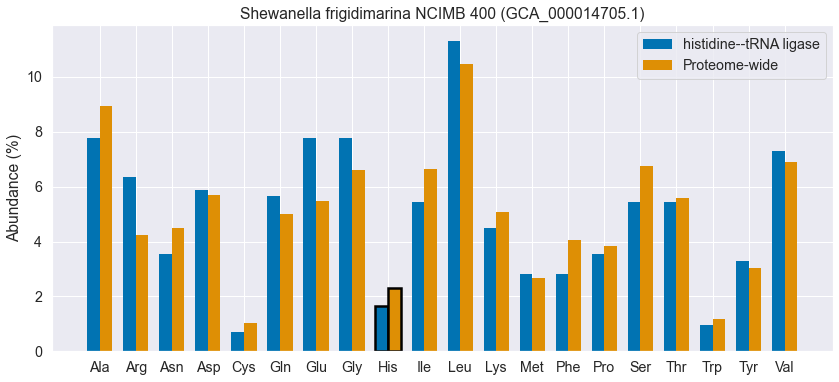

In [62]:
ax = plot_protein_aa_distribution_versus_proteome(
    assembly_df, 
    assembly_id, 
    tigr_id='TIGR00442'
)

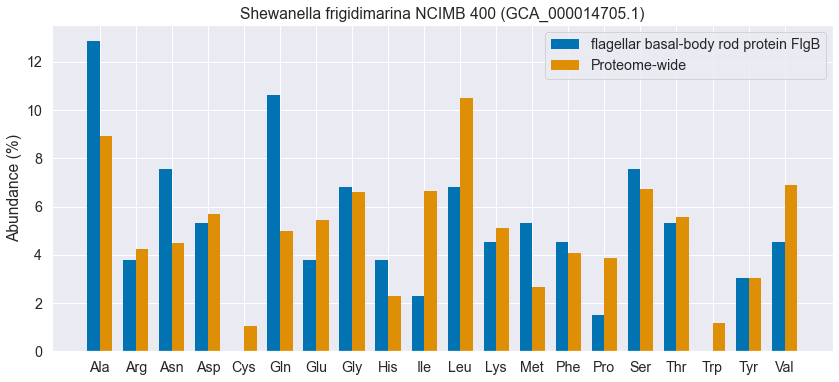

In [76]:
ax = plot_protein_aa_distribution_versus_proteome(
    assembly_df, 
    assembly_id, 
    tigr_id='TIGR01396'
)

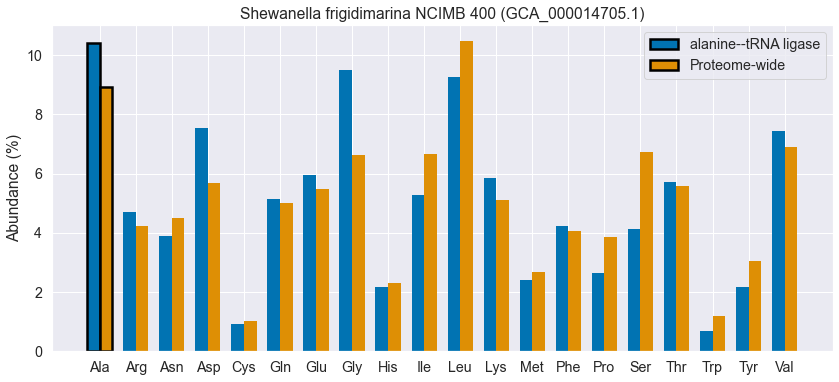

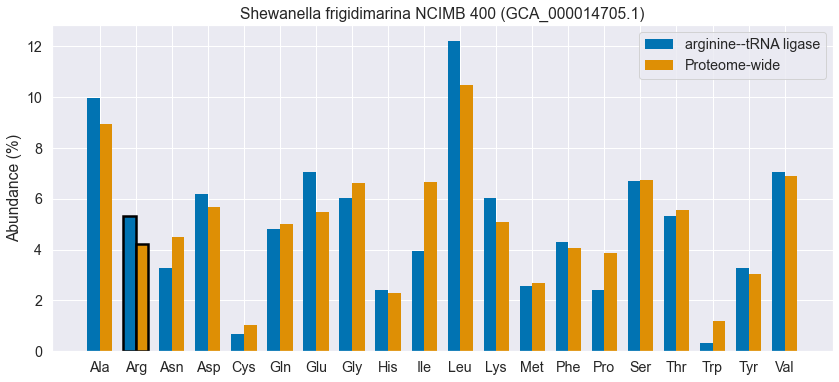

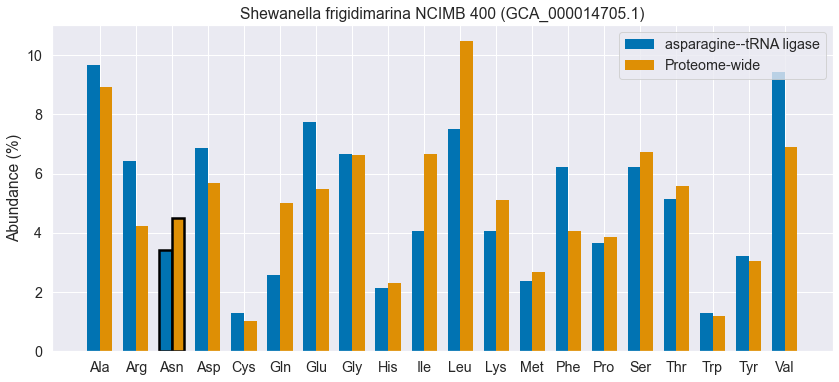

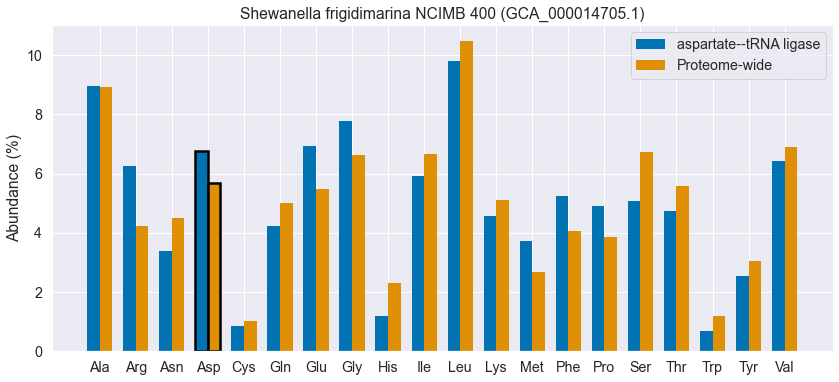

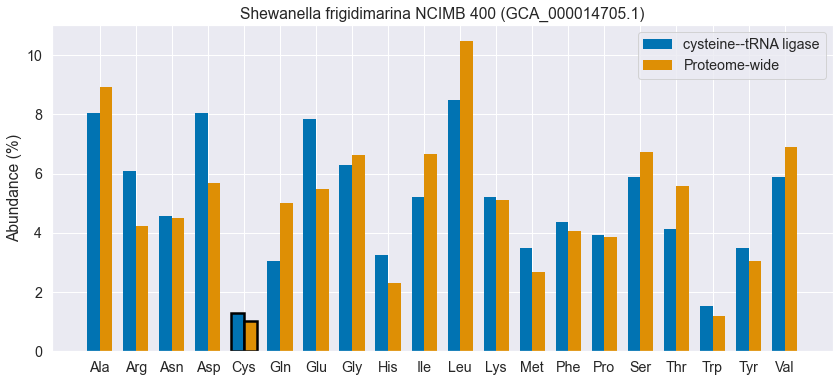

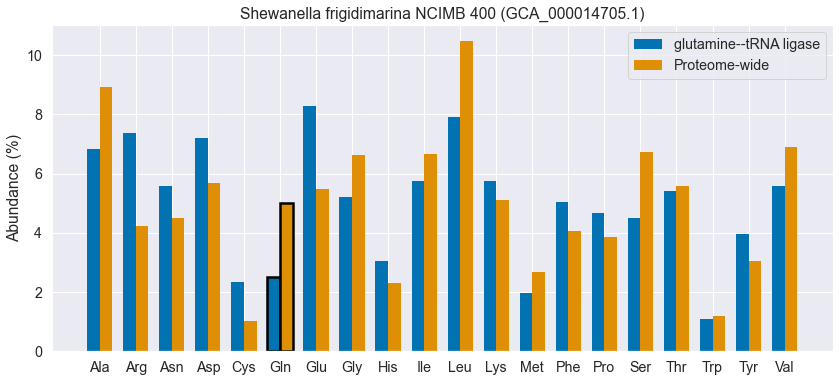

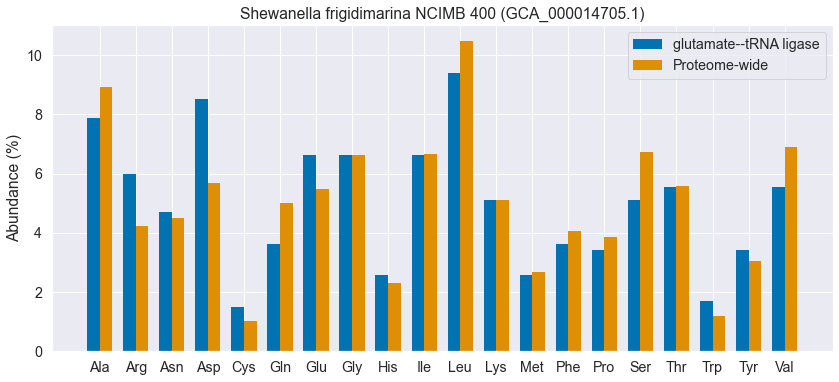

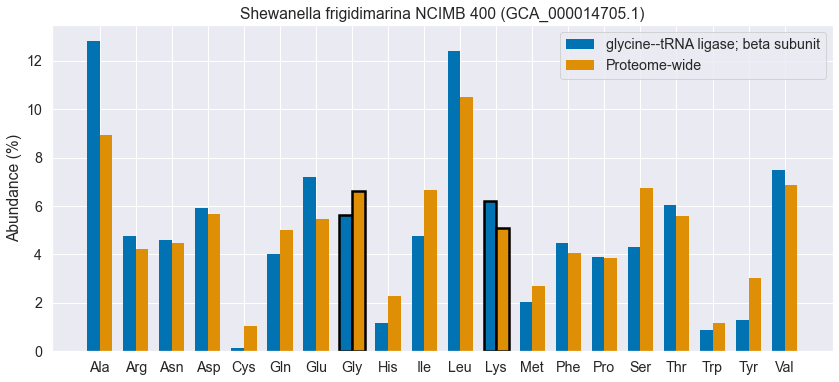

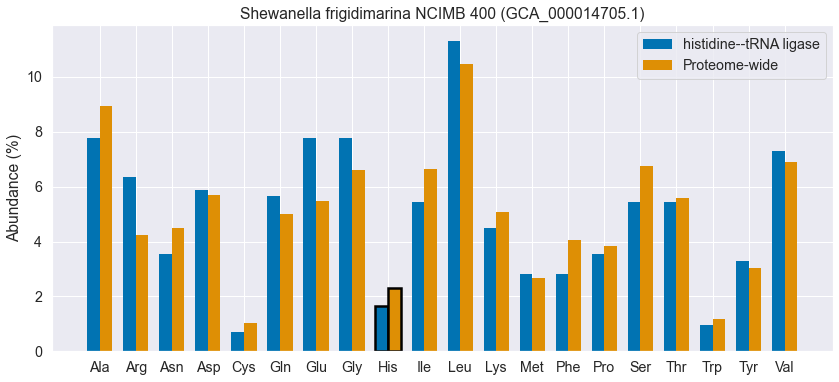

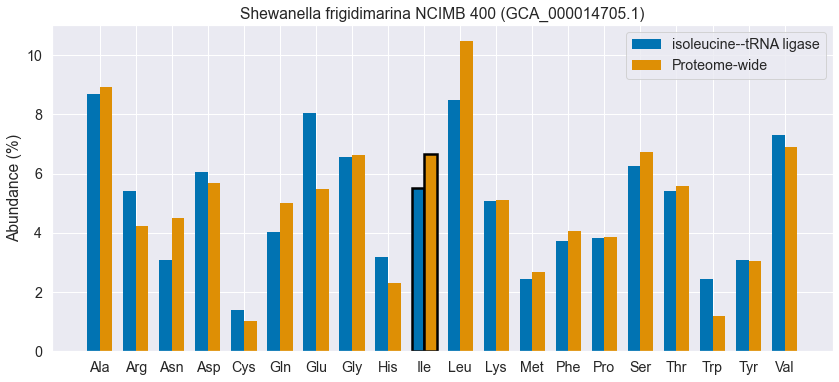

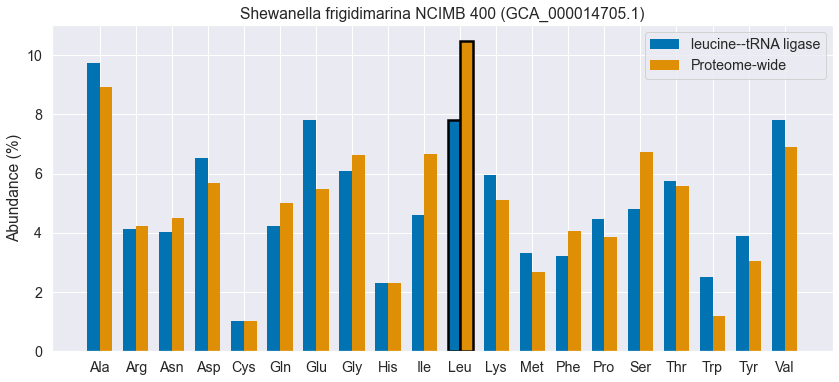

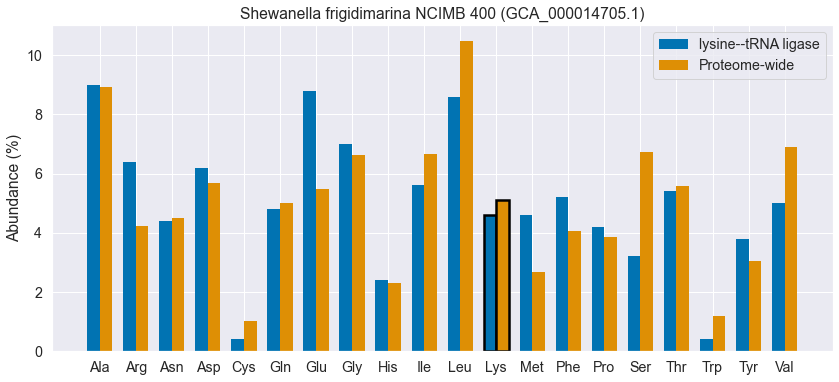

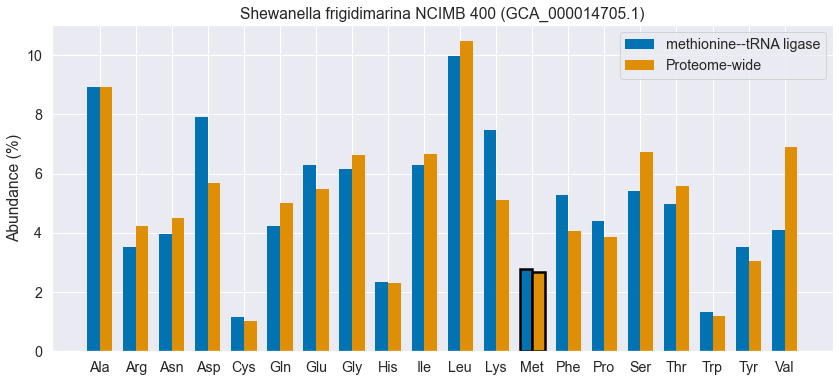

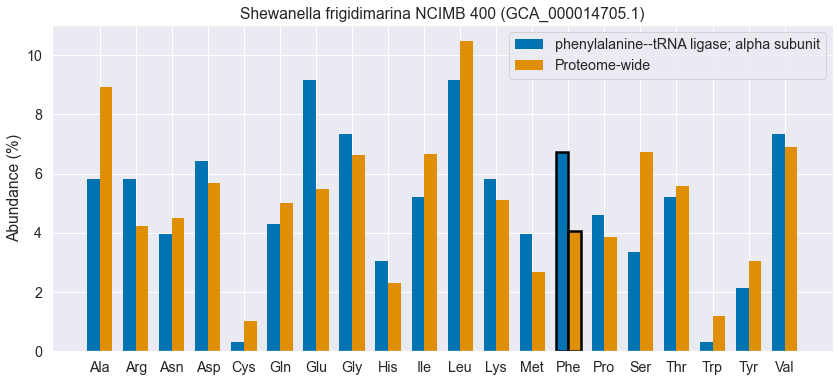

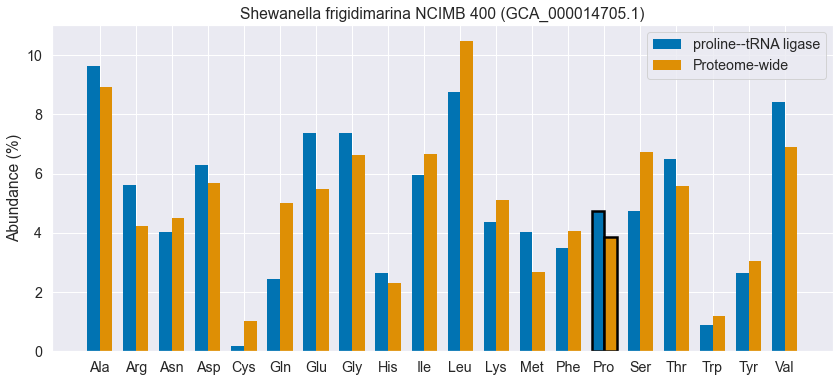

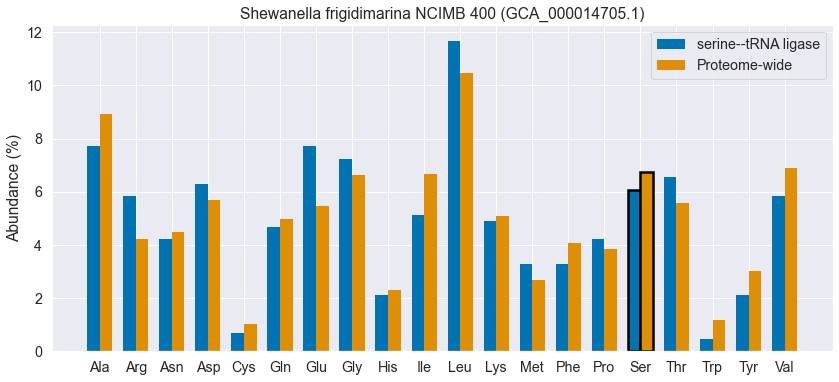

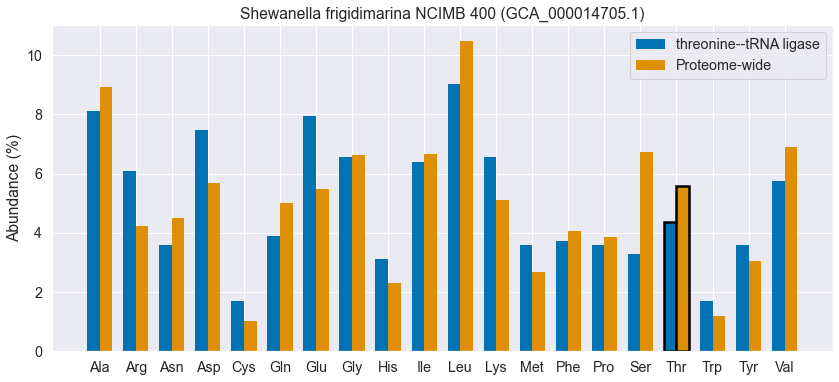

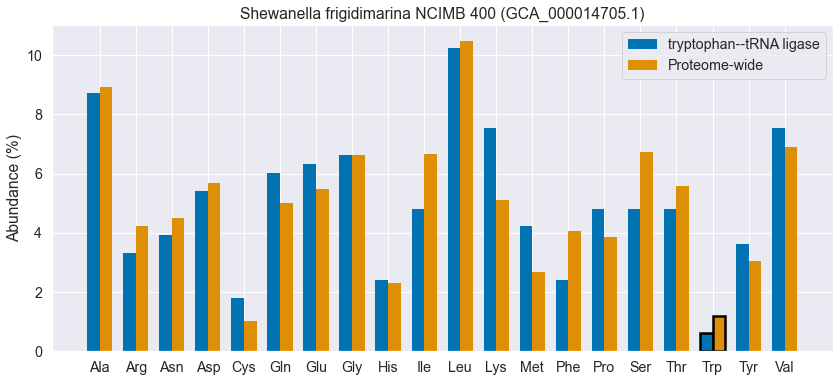

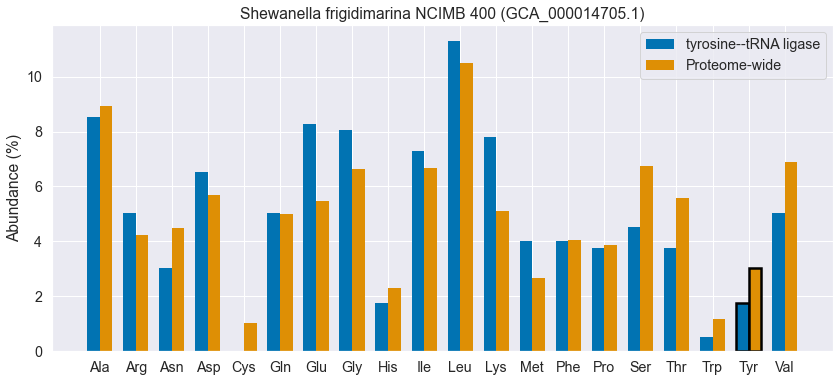

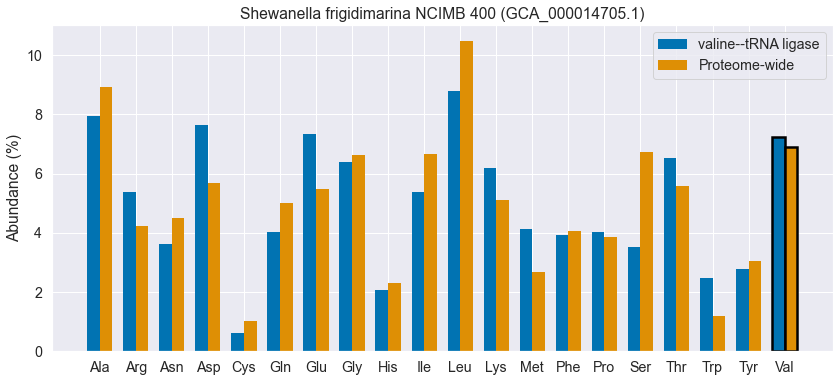

In [99]:
for aa, tigr_ids in trna_synt_tigr_ids.items():
    for tigr_id in tigr_ids:
        try:
            plot_protein_aa_distribution_versus_proteome(
                assembly_df, 
                assembly_id, 
                tigr_id,
            );
            break
        except KeyError:
            continue

## Sample assemblies from a variety of phylum

In [100]:
def sample_assemblies_by_phylum(df, n_per_phylum=5, seed=444):
    rs = np.random.RandomState(seed)
    phyla = df['phylum'].unique()
    
    assembly_list = []
    for phylum in phyla:
        phylum_index = df[df['phylum'] == phylum].index.tolist()
        
        if len(phylum_index) <= n_per_phylum:
            assembly_list += phylum_index
        else:
            assembly_list += rs.choice(phylum_index, replace=False, size=n_per_phylum).tolist()
            
    return df.loc[assembly_list].copy()

In [125]:
sample_df = sample_assemblies_by_phylum(complete_genomes_df, n_per_phylum=1)
len(sample_df)

53

In [135]:
def plot_grid(df, tigr_ids, relevant_aa=None):
    if len(df) % 2 != 0:
        ix = df.index[:-1]
    else:
        ix = df.index
        
    n_cols = 2
    n_rows = int(len(ix) / 2)
    
    f, axes = plt.subplots(n_rows, n_cols, figsize=(22, 8 * n_rows))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        assembly_id = ix[i]
        for tigr_id in tigr_ids:
            try:
                plot_protein_aa_distribution_versus_proteome(
                    df, 
                    assembly_id, 
                    tigr_id,
                    ax=ax,
                    compact=True,
                    relevant_aa=relevant_aa,
                );
                break
            except (KeyError, AssertionError):
                ax.set_title(assembly_id)
                continue
                
    return f

In [134]:
f = plot_grid(sample_df, tigr_ids=['TIGR00442']);
f.clear()

<Figure size 1584x14976 with 0 Axes>

In [136]:
for aa, tigr_ids in trna_synt_tigr_ids.items():
    print(aa)
    out_path = os.path.join(cwd, f'data/aa_distributions/{aa}.pdf')
    f = plot_grid(sample_df, tigr_ids=tigr_ids, relevant_aa=aa);
    f.savefig(out_path, bbox_inches='tight')
    f.clear()

Ala
Arg
Asn
Asp
Cys
Gln
Glt
Gly
His
Ile
Leu
Lys
Met
Phe
Pro
Ser
Thr
Trp
Tyr
Val


<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>

<Figure size 1584x14976 with 0 Axes>